# Numba vs. Cython: Take 2

*This notebook first appeared as a*
[*post*](http://jakevdp.github.io/blog/2012/08/24/numba-vs-cython/)
*by Jake Vanderplas on the blog*
[*Pythonic Perambulations*](http://jakevdp.github.io)

<!-- PELICAN_BEGIN_SUMMARY -->

Last summer I wrote a [post](http://jakevdp.github.io/blog/2012/08/24/numba-vs-cython/)
comparing the performance of [Numba](http://numba.pydata.org/) and [Cython](http://cython.org/)
for optimizing array-based computation.  Since posting, the page has received thousands of hits,
and resulted in a number of interesting discussions.
But in the meantime, the Numba package has come a long way both in its interface and its
performance.

Here I want to revisit those timing comparisons with a more recent Numba release, using the newer
and more convenient ``autojit`` syntax, and also add in a few additional benchmarks for
completeness.  I've also written this post entirely within an IPython notebook, so it can be
easily downloaded and modified.

As before, I'll use a **pairwise distance** function.  This will take an array representing
``M`` points in ``N`` dimensions, and return the ``M x M`` matrix of pairwise distances.
This is a nice test function for a few reasons.  First of all, it's a very clean and
well-defined test.  Second of all, it illustrates the kind of array-based operation that
is common in statistics, datamining, and machine learning.  Third, it is a function that
results in large memory consumption if the standard numpy broadcasting approach is used
(it requires a temporary array containing ``M * M * N``  elements), making it a good
candidate for an alternate approach.

<!-- PELICAN_END_SUMMARY -->

We'll start by defining the array which we'll use for the benchmarks: one thousand points in
three dimensions.

In [1]:
import numpy as np
X = np.random.random((1000, 3))

## Numpy Function With Broadcasting

We'll start with a typical numpy broadcasting approach to this problem.  Numpy
broadcasting is an abstraction that allows loops over array indices to be
executed in compiled C.  For many applications, this is extremely fast and efficient.
Unfortunately, there is a problem with broadcasting approaches that comes up here:
it ends up allocating hidden temporary arrays which can eat up memory and cause
computational overhead.  Nevertheless, it's a good comparison to have.  The function
looks like this:

In [2]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1))
%timeit pairwise_numpy(X)

10 loops, best of 3: 111 ms per loop


## Pure Python Function

A loop-based solution avoids the overhead associated with temporary arrays,
and can be written like this:

In [3]:
def pairwise_python(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D
%timeit pairwise_python(X)

1 loops, best of 3: 13.4 s per loop


As we see, it is over 100 times slower than the numpy broadcasting approach!
This is due to Python's dynamic type checking, which can drastically slow down
nested loops.  With these two solutions, we're left with a tradeoff between
efficiency of computation and efficiency of memory usage.  This is where tools
like Numba and Cython become vital

I should note that there exist alternative Python interpreters which improve
on the computational inefficiency of the Python run-time, one of which is
the popular [PyPy](http://pypy.org/) project.
PyPy is extremely interesting.  However,
it's currently all but useless for scientific applications,
because it does not support NumPy, and by extension cannot run
code based on SciPy, scikit-learn, matplotlib, or virtually any other
package that makes Python a useful tool for scientific computing.
For that reason, I won't consider PyPy here.

## Numba Wrapper

[Numba](http://numba.pydata.org/) is an LLVM compiler for python code, which
allows code written in Python to be converted to highly efficient compiled code
in real-time.  Due to its dependencies, compiling it can be a challenge.  To experiment
with Numba, I recommend using a local installation of [Anaconda](https://store.continuum.io/),
the free cross-platform Python distribution which includes Numba and all its prerequisites
within a single easy-to-install package.

Numba is extremely simple to use.  We just wrap our python function with ``autojit`` (JIT stands
for "just in time" compilation) to automatically create an efficient, compiled version of the function:

In [4]:
from numba import double
from numba.decorators import jit, autojit

pairwise_numba = autojit(pairwise_python)

%timeit pairwise_numba(X)

1 loops, best of 3: 9.12 ms per loop


Adding this simple expression speeds up our execution by over a factor of over 1400!
For those keeping track, this is about 50% faster than the version of Numba that
I tested last August on the same machine.

## Optimized Cython Function

[Cython](http://cython.org) is another package which is built to convert Python-like statemets
into compiled code. The language is actually a superset of Python which acts as a sort of
hybrid between Python and C.  By adding type annotations to Python code and running
it through the Cython interpreter, we obtain fast compiled code.  Here is a
highly-optimized Cython version of the pairwise distance function, which we compile
using IPython's Cython magic:

In [5]:
%load_ext cythonmagic

In [6]:
%%cython

import numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)

In [7]:
%timeit pairwise_cython(X)

100 loops, best of 3: 9.87 ms per loop


The Cython version, despite all the optimization, is a few percent *slower* than
the result of the simple Numba decorator!  I should emphasize here that I have
years of experience with Cython, and in this function I've used every Cython
optimization there is
(if any Cython super-experts are out there and would like to correct me
on that, please let me know in the blog comment thread!)  By comparison, the Numba
version is a simple, unadorned wrapper around plainly-written Python code.

## Fortran/F2Py

Another option for fast computation is to write a Fortran function directly, and use
the ``f2py`` package to interface with the function.  We can write the function
as follows:

In [8]:
%%file pairwise_fort.f

      subroutine pairwise_fort(X,D,m,n)
          integer :: n,m
          double precision, intent(in) :: X(m,n)
          double precision, intent(out) :: D(m,m) 
          integer :: i,j,k
          double precision :: r 
          do i = 1,m 
              do j = 1,m 
                  r = 0
                  do k = 1,n 
                      r = r + (X(i,k) - X(j,k)) * (X(i,k) - X(j,k)) 
                  end do 
                  D(i,j) = sqrt(r) 
              end do 
          end do 
      end subroutine pairwise_fort

Writing pairwise_fort.f


We can then use the shell interface to compile the Fortran function.  In order
to hide the output of this operation, we direct it into ``/dev/null`` (note: I
tested this on Linux, and it may have to be modified for Mac or Windows).

In [9]:
# Compile the Fortran with f2py.
# We'll direct the output into /dev/null so it doesn't fill the screen
!f2py -c pairwise_fort.f -m pairwise_fort > /dev/null

We can import the resulting code into Python to time the execution
of the function.  To make sure we're being fair, we'll first convert
the test array to Fortran-ordering so that no conversion needs to
happen in the background:

In [10]:
from pairwise_fort import pairwise_fort
XF = np.asarray(X, order='F')
%timeit pairwise_fort(XF)

100 loops, best of 3: 16.7 ms per loop


The result is nearly a factor of two slower than the Cython and Numba versions.

Now, I should note here that I am most definitely **not** an expert on Fortran, so
there may very well be optimizations missing from the above code.  If you see any
obvious problems here, please let me know in the blog comments.

## Scipy Pairwise Distances

Because pairwise distances are such a commonly used application in scientific
computing, both Scipy and scikit-learn have optimized routines to compute them.
The Scipy version is a Python wrapper of C code, and can be called as follows:

In [11]:
from scipy.spatial.distance import cdist
%timeit cdist(X, X)

100 loops, best of 3: 12.9 ms per loop


``cdist`` is about 50% slower than Numba.

## Scikit-learn Pairwise Distances

Scikit-learn contains the ``euclidean_distances`` function, works on sparse
matrices as well as numpy arrays, and is implemented in Cython:

In [12]:
from sklearn.metrics import euclidean_distances
%timeit euclidean_distances(X, X)

10 loops, best of 3: 35.6 ms per loop


``euclidean_distances`` is several times slower than the Numba pairwise function
on dense arrays.

## Comparing the Results

Out of all the above pairwise distance methods, unadorned Numba is the clear winner,
with highly-optimized Cython coming in a close second.  Both beat out the other
options by a large amount.

As a summary of the results, we'll create a bar-chart to visualize the timings:

*Edit: I changed the "fortran" label to "fortran/f2py" to make clear that this
is not raw Fortran.*

In [13]:
%pylab inline


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.


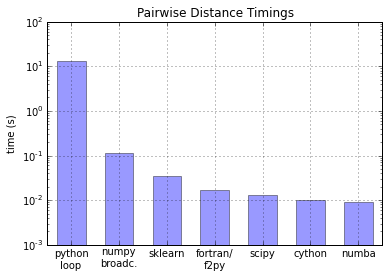

In [14]:
labels = ['python\nloop', 'numpy\nbroadc.', 'sklearn', 'fortran/\nf2py', 'scipy', 'cython', 'numba']
timings = [13.4, 0.111, 0.0356, 0.0167, 0.0129, 0.00987, 0.00912]
x = np.arange(len(labels))

ax = plt.axes(xticks=x, yscale='log')
ax.bar(x - 0.3, timings, width=0.6, alpha=0.4, bottom=1E-6)
ax.grid()
ax.set_xlim(-0.5, len(labels) - 0.5)
ax.set_ylim(1E-3, 1E2)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda i, loc: labels[int(i)]))
ax.set_ylabel('time (s)')
ax.set_title("Pairwise Distance Timings")

Note that this is log-scaled, so the vertical space between two
grid lines indicates a factor of 10 difference in computation time!

When I compared Cython and Numba last August, I found that Cython was about
30% faster than Numba.  Since then, Numba has had a few more releases, and both
the interface and the performance has improved.  On
top of being much easier to use (i.e. automatic type inference by ``autojit``)
it's now about 50% faster, and is even a few percent faster than the Cython option.

And though I've seen similar things for months, I'm still incredibly impressed
by the results enabled by Numba: *a single function decorator results in a
1300x speedup of simple Python code.*
I'm becoming more and more convinced that Numba is
the future of fast scientific computing in Python.

*This post was written entirely as an IPython notebook.* 
*The full notebook can be downloaded* 
[*here*](http://jakevdp.github.io/downloads/notebooks/NumbaCython.ipynb), 
*or viewed statically on* 
[*nbviewer*](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/NumbaCython.ipynb)